Naive: Pattern 'ABABCABAB' in text -> [10]
KMP: Pattern 'ABABCABAB' in text -> [10]
✅ Saved GIF: kmp_animation.gif


Rabin-Karp: Pattern 'ABABCABAB' in text -> [10] (mod=101)
✅ Saved GIF: rabin_karp_animation.gif


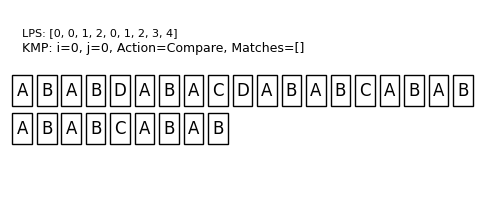

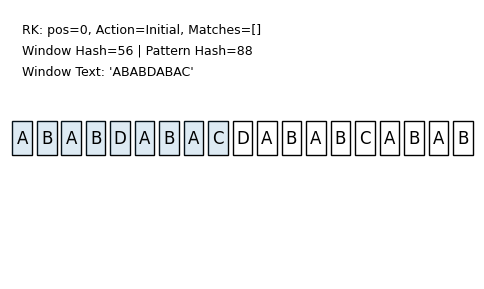

In [7]:
import time
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

# ------------------ Naive Search ------------------
def naive_search(pat, txt):
    n, m = len(txt), len(pat)
    occurrences = []
    for i in range(n - m + 1):
        if txt[i:i + m] == pat:
            occurrences.append(i)
    print(f"Naive: Pattern '{pat}' in text -> {occurrences if occurrences else 'None'}")
    return occurrences

# ------------------ KMP Helpers and Animated Search ------------------
def compute_lps(pattern):
    m = len(pattern)
    lps = [0] * m
    length = 0
    i = 1
    while i < m:
        if pattern[i] == pattern[length]:
            length += 1
            lps[i] = length
            i += 1
        else:
            if length != 0:
                length = lps[length - 1]
            else:
                lps[i] = 0
                i += 1
    return lps

def kmp_search_anim(pat, txt, interval=250):
    n, m = len(txt), len(pat)
    lps = compute_lps(pat)
    occurrences = []
    step_data = []
    i, j = 0, 0
    while i < n:
        step_data.append((i, j, occurrences.copy(), "Compare"))
        if pat[j] == txt[i]:
            i += 1
            j += 1
            if j == m:
                occurrences.append(i - j)
                step_data.append((i, j, occurrences.copy(), "Match Found"))
                j = lps[j - 1]
        else:
            if j != 0:
                j = lps[j - 1]
                step_data.append((i, j, occurrences.copy(), "Fallback"))
            else:
                i += 1
                step_data.append((i, j, occurrences.copy(), "Advance"))

    print(f"KMP: Pattern '{pat}' in text -> {occurrences if occurrences else 'None'}")

    # Visualization setup
    fig, ax = plt.subplots(figsize=(max(6, n * 0.25), 2.5))
    ax.set_xlim(-0.5, n - 0.5)
    ax.set_ylim(-2, 3)
    ax.axis("off")

    # Text row
    for idx, ch in enumerate(txt):
        rect = plt.Rectangle((idx - 0.4, 0.5), 0.8, 0.8, fill=False)
        ax.add_patch(rect)
        ax.text(idx, 0.9, ch, ha="center", va="center", fontsize=12)

    # Pattern row
    pattern_boxes = [plt.Rectangle((i - 0.4, -0.5), 0.8, 0.8, fill=False) for i in range(m)]
    for rect in pattern_boxes:
        ax.add_patch(rect)
    pattern_texts = [ax.text(i, -0.1, pat[i], ha="center", va="center", fontsize=12) for i in range(m)]
    status = ax.text(0, 2.0, "", ha="left", va="center", fontsize=9)
    lps_display = ax.text(0, 2.4, f"LPS: {lps}", ha="left", va="center", fontsize=8)

    def update(frame):
        i, j, occ, action = frame
        alignment_shift = i - j
        for idx in range(m):
            pattern_boxes[idx].set_xy((idx + alignment_shift - 0.4, -0.5))
            pattern_texts[idx].set_x(idx + alignment_shift)
            pattern_boxes[idx].set_edgecolor("black")
        # cleanup previous overlays
        for patch in [p for p in ax.patches if getattr(p, "custom_occ", False)]:
            patch.remove()
        # highlight found occurrences
        for oc in occ:
            for k in range(m):
                overlay = plt.Rectangle((oc + k - 0.4, 0.5), 0.8, 0.8, fill=True, alpha=0.25)
                overlay.custom_occ = True
                ax.add_patch(overlay)
        # current comparison
        if 0 <= i - 1 < len(txt) and 0 <= j - 1 < m:
            pattern_boxes[j - 1].set_edgecolor("red")
            rect = plt.Rectangle((i - 1 - 0.4, 0.5), 0.8, 0.8, fill=False, edgecolor="red", linewidth=2)
            rect.custom_occ = True
            ax.add_patch(rect)
        status.set_text(f"KMP: i={i}, j={j}, Action={action}, Matches={occ}")
        return pattern_boxes + pattern_texts + [status, lps_display]

    anim = FuncAnimation(fig, update, frames=step_data, interval=interval, blit=False, repeat=False)
    return anim, occurrences

# ------------------ Rabin-Karp Animated Search ------------------
def rabin_karp_search_anim(pat, txt, base=256, mod=101, interval=300):
    n, m = len(txt), len(pat)
    if m > n:
        print("Rabin-Karp: pattern longer than text, no matches.")
        return None, []
    h = pow(base, m - 1, mod)
    pat_hash = 0
    window_hash = 0
    occurrences = []
    step_data = []

    for i in range(m):
        pat_hash = (base * pat_hash + ord(pat[i])) % mod
        window_hash = (base * window_hash + ord(txt[i])) % mod
    step_data.append((0, window_hash, pat_hash, occurrences.copy(), "Initial"))

    for i in range(n - m + 1):
        if i > 0:
            window_hash = (window_hash - ord(txt[i - 1]) * h) % mod
            window_hash = (window_hash * base + ord(txt[i + m - 1])) % mod
            window_hash = (window_hash + mod) % mod
            step_data.append((i, window_hash, pat_hash, occurrences.copy(), "Roll"))

        if window_hash == pat_hash:
            if txt[i:i + m] == pat:
                occurrences.append(i)
                step_data.append((i, window_hash, pat_hash, occurrences.copy(), "Match Verified"))
            else:
                step_data.append((i, window_hash, pat_hash, occurrences.copy(), "Spurious Hit"))
        else:
            step_data.append((i, window_hash, pat_hash, occurrences.copy(), "No Match"))

    print(f"Rabin-Karp: Pattern '{pat}' in text -> {occurrences if occurrences else 'None'} (mod={mod})")

    fig, ax = plt.subplots(figsize=(max(6, n * 0.25), 3.5))
    ax.set_xlim(-0.5, n - 0.5)
    ax.set_ylim(-2.5, 4)
    ax.axis("off")
    for idx, ch in enumerate(txt):
        rect = plt.Rectangle((idx - 0.4, 0.5), 0.8, 0.8, fill=False)
        ax.add_patch(rect)
        ax.text(idx, 0.9, ch, ha="center", va="center", fontsize=12)

    status = ax.text(0, 3.5, "", ha="left", va="center", fontsize=9)
    hash_info = ax.text(0, 3.0, "", ha="left", va="center", fontsize=9)
    window_info = ax.text(0, 2.5, "", ha="left", va="center", fontsize=9)

    def update(frame):
        i, w_hash, p_hash, occ, action = frame
        for patch in [p for p in ax.patches if getattr(p, "custom_occ", False)]:
            patch.remove()
        for k in range(m):
            win_rect = plt.Rectangle((i + k - 0.4, 0.5), 0.8, 0.8, fill=True, alpha=0.15)
            win_rect.custom_occ = True
            ax.add_patch(win_rect)
        for oc in occ:
            for k in range(m):
                overlay = plt.Rectangle((oc + k - 0.4, 0.5), 0.8, 0.8, fill=True, alpha=0.3, edgecolor="green")
                overlay.custom_occ = True
                ax.add_patch(overlay)
        status.set_text(f"RK: pos={i}, Action={action}, Matches={occ}")
        hash_info.set_text(f"Window Hash={w_hash} | Pattern Hash={p_hash}")
        window_info.set_text(f"Window Text: '{txt[i:i+m]}'")
        return [status, hash_info, window_info]

    anim = FuncAnimation(fig, update, frames=step_data, interval=interval, blit=False, repeat=False)
    return anim, occurrences

# ------------------ Save GIF Only ------------------
def save_gif_only(anim, name_prefix):
    if anim is None:
        print(f"No animation for {name_prefix}")
        return
    gif_path = f"{name_prefix}.gif"
    try:
        anim.save(gif_path, writer="pillow")
        print(f"✅ Saved GIF: {gif_path}")
    except Exception as e:
        print(f"❌ GIF save failed: {e}")
    display(HTML(f"### {name_prefix}")) 
    display(HTML(f'<img src="{gif_path}" alt="{name_prefix}">'))

# ------------------ Example Execution ------------------
text = "ABABDABACDABABCABAB"
pattern = "ABABCABAB"

# 1. Naive (no animation)
naive_search(pattern, text)

# 2. KMP animation + GIF export
kmp_anim, kmp_occ = kmp_search_anim(pattern, text)
save_gif_only(kmp_anim, "kmp_animation")

# 3. Rabin-Karp animation + GIF export
rk_anim, rk_occ = rabin_karp_search_anim(pattern, text)
save_gif_only(rk_anim, "rabin_karp_animation")
